In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

import joblib


In [49]:
# Load Titanic data
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [51]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [52]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# **Target varuable distribution**

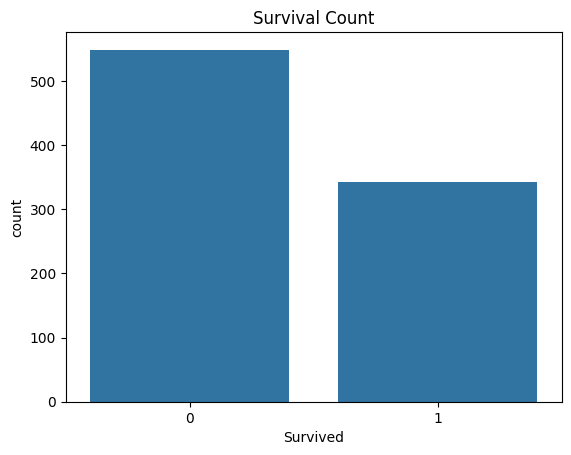

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [53]:
sns.countplot(x="Survived", data=df)
plt.title("Survival Count")
plt.show()

print(df['Survived'].value_counts(normalize=True))


Around 62% did not survive, so there is some class imbalance. This means we need to use evaluation metrics like:

Precision / Recall

ROC-AUC

# Gender VS Survival

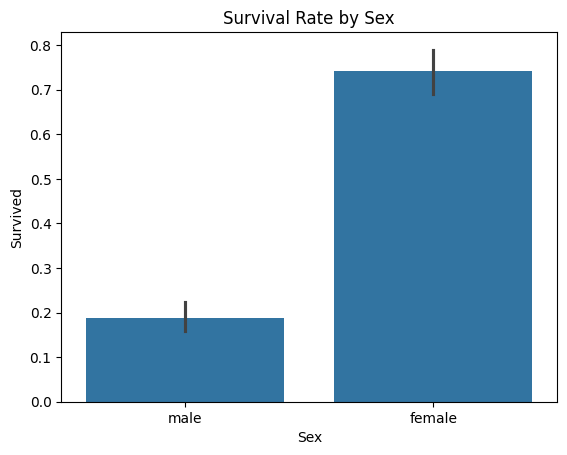

In [54]:
sns.barplot(x="Sex", y="Survived", data=df)
plt.title("Survival Rate by Sex")
plt.show()


Women survived at a much higher rate → Sex is likely a strong predictive feature.

# Age VS Survival

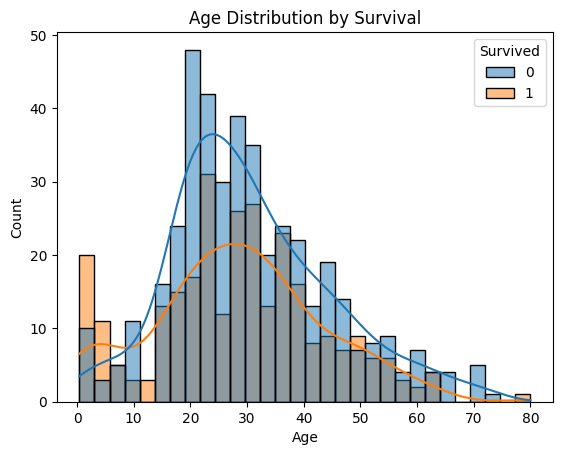

In [55]:
sns.histplot(data=df, x="Age", hue="Survived", bins=30, kde=True)
plt.title("Age Distribution by Survival")
plt.show()



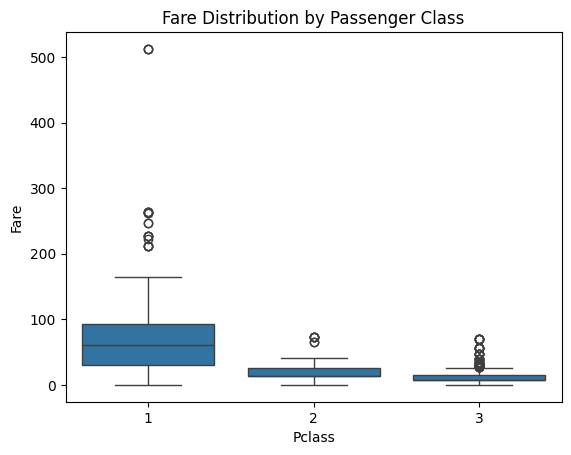

In [56]:
sns.boxplot(x="Pclass", y="Fare", data=df)
plt.title("Fare Distribution by Passenger Class")
plt.show()


Higher class = more expensive tickets.
Fare is right-skewed with large range ->  Standardization needed

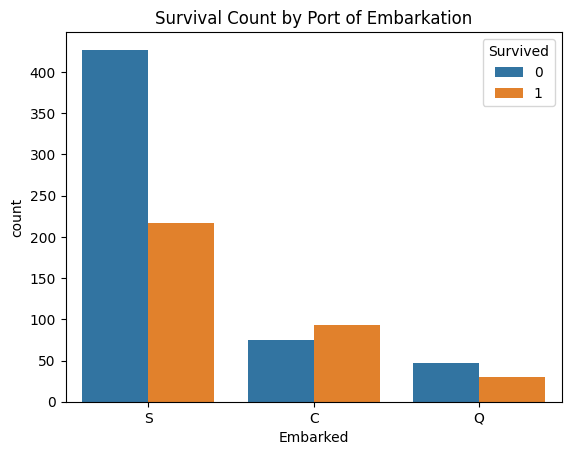

In [57]:
sns.countplot(x="Embarked", hue="Survived", data=df)
plt.title("Survival Count by Port of Embarkation")
plt.show()


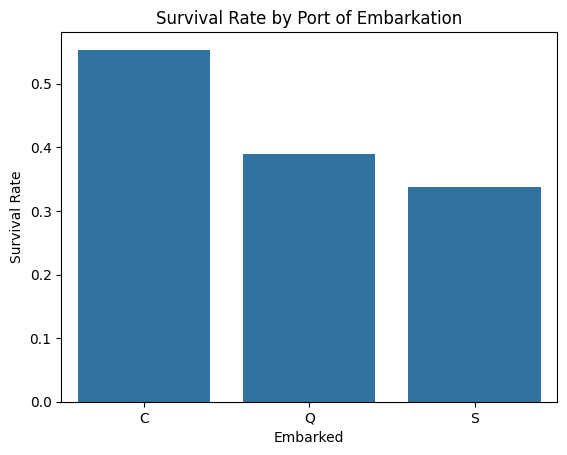

In [58]:
# Survival rate per embarkation port
survival_rate_by_embarked = df.groupby("Embarked")["Survived"].mean().sort_values(ascending=False)

# Plot
sns.barplot(x=survival_rate_by_embarked.index, y=survival_rate_by_embarked.values)
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Port of Embarkation")
plt.show()

# **Pre-processing**

In [59]:
df_clean = df.copy()

Removing columns that don't provide useful information for prediction.

In [60]:
df_clean.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)


IsAlone : A binary feature that indicates whether a passenger was traveling alone. This is done by summing the values of SibSp (number of siblings/spouses aboard) and Parch (number of parents/children aboard).
If the sum is zero, it means the passenger was alone, so we assign a value of 1. Otherwise, we assign 0.

In [61]:
# 'IsAlone' is 1 if the passenger has no siblings/spouses or parents/children aboard, else 0

df_clean["IsAlone"] = ((df_clean["SibSp"] + df_clean["Parch"]) == 0).astype(int)

In [62]:
df_clean.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone
0,0,3,male,22.0,1,0,7.2500,S,0
1,1,1,female,38.0,1,0,71.2833,C,0
2,1,3,female,26.0,0,0,7.9250,S,1
3,1,1,female,35.0,1,0,53.1000,S,0
4,0,3,male,35.0,0,0,8.0500,S,1


# **Splitting the data**

We're splitting at this point in the pre-processing to avoid data leakage

In [63]:
# Defining features and target
X = df_clean.drop("Survived", axis=1)
y = df_clean["Survived"]

In [64]:
# Spliting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
# Preprocessing for numeric features
numeric_features = ["Age", "Fare", "SibSp", "Parch", "IsAlone"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # Replacing missing values with median
    ("scaler", StandardScaler())                     # Scaling numerical features
])

Pipeline documentation : https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [66]:
# Preprocessing for categorical features
categorical_features = ["Sex", "Embarked","Pclass"]
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Replacing missing values with mode
    ("onehot", OneHotEncoder(handle_unknown="ignore"))      # One-hot encoding categorical features
])


ColumnTransformer documentation : https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

The ColumnTransformer lets you apply different preprocessing steps to different columns in your dataset all in one go. Instead of manually transforming each column and stitching them back together, ColumnTransformer handles this automatically

In [67]:
# Combining preprocessing for both numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [68]:
# Fitting the preprocessor on the training data and applying the transformations to both train and test sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Check the output shape to confirm everything is correct
X_train_processed.shape, X_test_processed.shape


((712, 13), (179, 13))

In [69]:

joblib.dump({
    "df_clean": df_clean,               # Cleaned DataFrame (EDA or backup)
    "X_train": X_train,                 # Raw training features
    "X_test": X_test,                   # Raw testing features
    "y_train": y_train,                 # Target training
    "y_test": y_test,                   # Target testing
    "preprocessor": preprocessor,       # Pipeline used to transform data
    "X_train_processed": X_train_processed,  # Transformed training data
    "X_test_processed": X_test_processed     # Transformed testing data
}, "titanic_full_preprocessing.pkl")


['titanic_full_preprocessing.pkl']